In [1]:
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling, plotDistanceToUpstreamKinase
from msresist.figures.figure1 import plot_phenotype_heatmap
from msresist.figures.figure2 import plotCenters_together, ComputeCenters
from msresist.pca import plotPCA
from msresist.pre_processing import preprocessing
from msresist.clustering import DDMC
from msresist.plsr import plotStripActualVsPred, plotScoresLoadings
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)

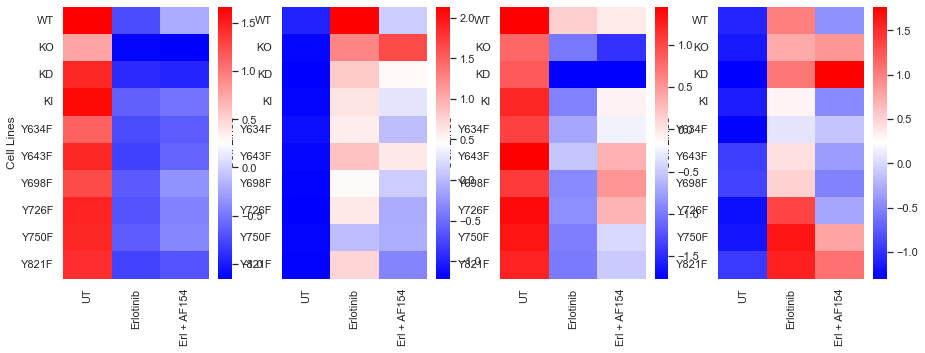

In [4]:
_, ax = plt.subplots(1, 4, figsize=(15, 5))
plot_phenotype_heatmap(ax[0], y[["Lines", "Treatment", "Viability"]])
plot_phenotype_heatmap(ax[1], y[["Lines", "Treatment", "Apoptosis"]])
plot_phenotype_heatmap(ax[2], y[["Lines", "Treatment", "Migration"]])
plot_phenotype_heatmap(ax[3], y[["Lines", "Treatment", "Island"]])

No handles with labels found to put in legend.


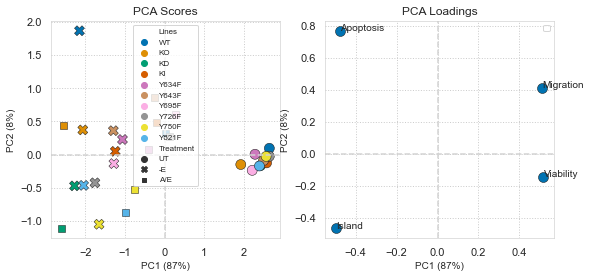

In [5]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
plotPCA(ax, y, 2, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", legendOut=False)
plt.savefig("pheno_pca.svg")

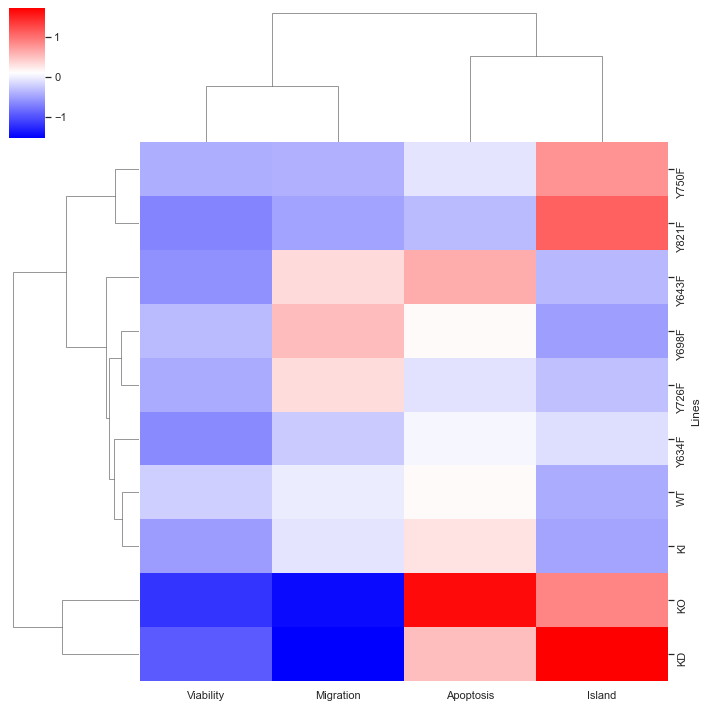

In [6]:
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")
sns.clustermap(y, robust=True, cmap="bwr")

In [7]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

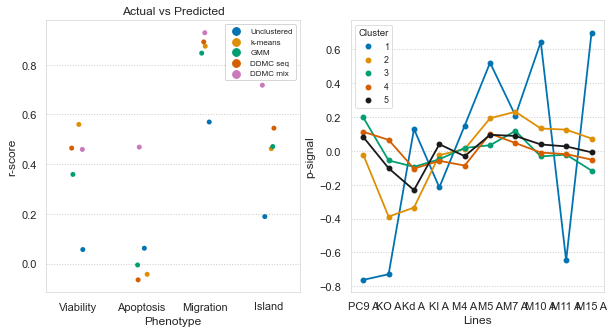

In [8]:
# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5)
Xs, models = ComputeCenters(X, d, i, ddmc)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotStripActualVsPred(ax[0], [2, 2, 2, 2, 2], Xs, y, models)

ddmc.fit(d)
centers = ddmc.transform()
plotCenters_together(ddmc, X, ax[1])

In [10]:
y

,Viability,Apoptosis,Migration,Island
Lines,,,,
WT,-0.208371,0.130054,-0.027686,-0.431701
KO,-1.186327,1.638908,-1.443968,0.863908
KD,-0.945429,0.507669,-1.774300,1.940950
KI,-0.523357,0.281607,-0.080186,-0.483639
Y634F,-0.641293,0.034040,-0.244996,-0.119054
Y643F,-0.597937,0.613719,0.327549,-0.356083
Y698F,-0.343488,0.127568,0.516946,-0.514497
Y726F,-0.437530,-0.085242,0.309504,-0.306164
Y750F,-0.413532,-0.075235,-0.408378,0.775350


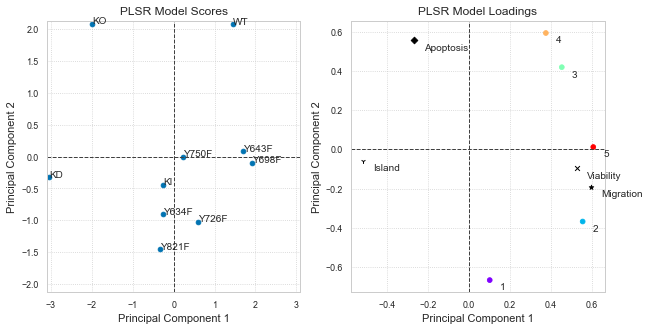

In [9]:
# Scores & Loadings
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plsr = PLSRegression(n_components=3)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ddmc.n_components, lines, pcX=1, pcY=2)

/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:172: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:188: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:172: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/Users/creixell/Desktop/UCLA/Projects/UO1/Computational/GitHub.tmp/AXLomics/msresist/clustering.py:188: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


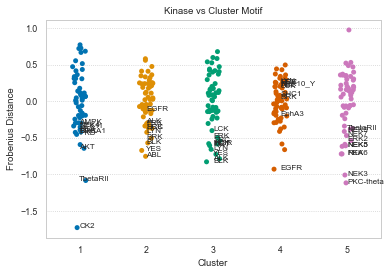

In [17]:
# Plot upstream kinases heatmap
_, ax = plt.subplots(1, 1)
plotDistanceToUpstreamKinase(ddmc, [1, 2, 3, 4, 5], ax, num_hits=10, PsP_background=True)